In [39]:
from miditoolkit import MidiFile

# Path to your MIDI file
path = "maestro-v3.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_02_ORIG_MID--AUDIO_21_R1_2004_03_Track03_wav.midi"

# Load the MIDI file
midi = MidiFile(path)

# Print basic info
print("Number of instrument tracks:", len(midi.instruments))
for i, inst in enumerate(midi.instruments):
    print(f"Instrument {i} | Program: {inst.program} | Notes: {len(inst.notes)}")
    print("Sample notes:", inst.notes[:5])


Number of instrument tracks: 1
Instrument 0 | Program: 0 | Notes: 6007
Sample notes: [Note(velocity=35, pitch=50, start=1287, end=1571), Note(velocity=37, pitch=53, start=1423, end=1660), Note(velocity=39, pitch=58, start=1560, end=1916), Note(velocity=40, pitch=46, start=1192, end=2563), Note(velocity=35, pitch=34, start=1002, end=3844)]


In [40]:
import os
import pretty_midi
import torch
from tqdm import tqdm

SEQ_LEN = 256
VOCAB_SIZE = 128

def extract_melody_harmony_from_midi(midi_file, seq_len=SEQ_LEN):
    try:
        midi = pretty_midi.PrettyMIDI(midi_file)
        notes = []
        for inst in midi.instruments:
            if not inst.is_drum:
                notes.extend(inst.notes)
        if len(notes) < seq_len:
            return None

        notes.sort(key=lambda n: n.start)
        start_time = notes[0].start
        end_time = notes[-1].end
        time_step = (end_time - start_time) / seq_len
        if time_step == 0:
            return None

        melody = [0] * seq_len
        harmony = [[0] * VOCAB_SIZE for _ in range(seq_len)]

        for note in notes:
            idx = int((note.start - start_time) / time_step)
            if 0 <= idx < seq_len and 0 <= note.pitch < VOCAB_SIZE:
                harmony[idx][note.pitch] = 1

        for i in range(seq_len):
            active = [p for p, v in enumerate(harmony[i]) if v]
            melody[i] = max(active) if active else 0

        return melody, harmony
    except:
        return None

def extract_from_folder(folder):
    pairs = []
    for root, _, files in os.walk(folder):
        for file in tqdm(files):
            if file.endswith(".mid") or file.endswith(".midi"):
                result = extract_melody_harmony_from_midi(os.path.join(root, file))
                if result:
                    pairs.append(result)
    print(f"✅ Extracted {len(pairs)} melody-harmony pairs")
    return pairs


In [41]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pretty_midi
from tqdm import tqdm

# ----- CONFIG -----
SEQ_LEN = 256
VOCAB_SIZE = 128
HIDDEN_SIZE = 256
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001

# ----- DATASET -----
class MaestroDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        melody, harmony = self.pairs[idx]
        return torch.tensor(melody, dtype=torch.long), torch.tensor(harmony, dtype=torch.float32)

# ----- MODEL -----
class ChordLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, vocab_size)

    def forward(self, x):
        x = self.embed(x)
        out, _ = self.lstm(x)
        logits = self.fc(out)
        return torch.sigmoid(logits)

# ----- TRAINING LOOP -----
def train(model, dataloader, epochs=EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.BCELoss()

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        print(f"\n🎵 Epoch {epoch}/{epochs}")
        for melody, harmony in dataloader:
            melody, harmony = melody.to(device), harmony.to(device)
            pred = model(melody)
            loss = loss_fn(pred, harmony)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"✅ Avg Loss: {total_loss / len(dataloader):.4f}")

# ----- GENERATION -----
def generate_chords(model, melody_seq, temperature=1.0):
    device = next(model.parameters()).device
    model.eval()
    with torch.no_grad():
        inp = melody_seq.clone().detach().unsqueeze(0).to(device)
        logits = model(inp).squeeze(0)
        probs = torch.sigmoid(logits / temperature)
        sampled = (probs > 0.5).int().tolist()
        return sampled

# ----- SAVE TO MIDI -----
def save_midi_with_chords(melody_seq, harmony_matrix, filename="output_song.mid"):
    midi = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)

    time = 0.0
    for i, melody_note in enumerate(melody_seq):
        dur = random.choice([0.125, 0.25, 0.375, 0.5])  # dynamic tempo
        end = time + dur

        if melody_note > 0:
            piano.notes.append(pretty_midi.Note(velocity=100, pitch=melody_note, start=time, end=end))

        # Add 1–3 top harmony notes
        active = [(p, v) for p, v in enumerate(harmony_matrix[i]) if v]
        top_pitches = sorted([p for p, _ in active])[:3]
        for j, pitch in enumerate(top_pitches):
            offset = j * 0.03
            piano.notes.append(pretty_midi.Note(velocity=80, pitch=pitch, start=time + offset, end=end))

        time = end

    midi.instruments.append(piano)
    midi.write(filename)
    print(f"🎼 Saved to {filename}")



In [43]:
pairs = extract_from_folder("maestro-v3.0.0")
dataset = MaestroDataset(pairs)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:09<00:00, 17.19it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 132/132 [00:12<00:00, 10.33it/s]

✅ Extracted 1275 melody-harmony pairs


In [44]:
model = ChordLSTM(VOCAB_SIZE, HIDDEN_SIZE)
train(model, loader)

for i in range(6):
    melody_sample, _ = random.choice(dataset)
    harmony = generate_chords(model, melody_sample)
    save_midi_with_chords(melody_sample.tolist(), harmony, f"final_song_{i+1}.mid")


🎵 Epoch 1/10
✅ Avg Loss: 0.2455

🎵 Epoch 2/10
✅ Avg Loss: 0.1728

🎵 Epoch 3/10
✅ Avg Loss: 0.1642

🎵 Epoch 4/10
✅ Avg Loss: 0.1597

🎵 Epoch 5/10
✅ Avg Loss: 0.1572

🎵 Epoch 6/10
✅ Avg Loss: 0.1553

🎵 Epoch 7/10
✅ Avg Loss: 0.1532

🎵 Epoch 8/10
✅ Avg Loss: 0.1519

🎵 Epoch 9/10
✅ Avg Loss: 0.1507

🎵 Epoch 10/10
✅ Avg Loss: 0.1496
🎼 Saved to final_song_1.mid
🎼 Saved to final_song_2.mid
🎼 Saved to final_song_3.mid
🎼 Saved to final_song_4.mid
🎼 Saved to final_song_5.mid
🎼 Saved to final_song_6.mid


In [72]:
melody_sample, harmony_gt = random.choice(dataset)
melody_sample = torch.tensor(melody_sample, dtype=torch.long)

# Generate LSTM prediction
lstm_harmony = generate_chords(model, melody_sample)

# Compute accuracy
accuracy = np.mean(np.array(lstm_harmony) == np.array(harmony_gt))
print("LSTM accuracy:", accuracy)

import numpy as np

def get_log_likelihood(harmony_gt, melody_seq):
    log_likelihoods = []

    for i, m in enumerate(melody_seq):
        chord_probs = melody_to_harmony_probs.get(m, {})
        
        # Get the ground-truth chord tuple
        gt_vector = harmony_gt[i]
        gt_chord = tuple(j for j, val in enumerate(gt_vector) if val > 0)

        prob = chord_probs.get(gt_chord, 1e-9)  # Use small value if not found
        log_likelihoods.append(np.log(prob))

    return np.mean(log_likelihoods)

# Use your current sample
melody_sample, harmony_gt = random.choice(dataset)
melody_seq = melody_sample.tolist()
harmony_gt = harmony_gt.tolist()

avg_log_likelihood = get_log_likelihood(harmony_gt, melody_seq)
print("🔢 HMM Log-Likelihood:", avg_log_likelihood)


LSTM accuracy: 0.063140869140625
🔢 HMM Log-Likelihood: -8.192738232610479


/var/folders/70/8_8180cx6kd1sd20ygcxjsk40000gn/T/ipykernel_31350/3354850401.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  melody_sample = torch.tensor(melody_sample, dtype=torch.long)
/var/folders/70/8_8180cx6kd1sd20ygcxjsk40000gn/T/ipykernel_31350/3354850401.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  accuracy = np.mean(np.array(lstm_harmony) == np.array(harmony_gt))


In [78]:

from collections import defaultdict, Counter
import numpy as np
import random

# ----- BUILD MELODY → HARMONY COUNTS -----
melody_to_harmony_counts = defaultdict(Counter)

for melody, harmony in dataset:
    for m, h in zip(melody.tolist(), harmony.tolist()):
        pitches = tuple(i for i, v in enumerate(h) if v > 0)
        melody_to_harmony_counts[m].update([pitches])

# ----- CONVERT TO PROBABILITIES -----
melody_to_harmony_probs = {}
for m, counter in melody_to_harmony_counts.items():
    total = sum(counter.values())
    melody_to_harmony_probs[m] = {
        chords: count / total for chords, count in counter.items()
    }

# ----- HMM INFERENCE FUNCTION -----
def hmm_generate_harmony(melody_seq):
    harmony_seq = []
    for m in melody_seq:
        chord_probs = melody_to_harmony_probs.get(m, {})
        if chord_probs:
            chords = random.choices(list(chord_probs.keys()), weights=chord_probs.values())[0]
        else:
            chords = ()
        onehot = [0] * VOCAB_SIZE
        for p in chords:
            onehot[p] = 1
        harmony_seq.append(onehot)
    return harmony_seq


In [79]:
def compute_hmm_accuracy(dataset, n_samples=10):
    correct = 0
    total = 0

    for _ in range(n_samples):
        melody, true_harmony = random.choice(dataset)
        pred_harmony = hmm_generate_harmony(melody.tolist())

        # Safety check: same length?
        if len(pred_harmony) != len(true_harmony):
            continue

        for pred_vec, true_vec in zip(pred_harmony, true_harmony.tolist()):
            if pred_vec == true_vec:  # list equality
                correct += 1
            total += 1

    acc = correct / total if total > 0 else 0
    print(f"HMM accuracy: {acc:.4f}")
    return acc



In [85]:
melody_sample, harmony_gt = random.choice(dataset)
hmm_harmony = hmm_generate_harmony(melody_sample.tolist())

from scipy.special import rel_entr
import numpy as np

# Flatten one-hot vectors to pitch counts
def get_pitch_distribution(harmony_seq):
    pitch_counts = np.sum(harmony_seq, axis=0)
    dist = pitch_counts / np.sum(pitch_counts)
    return dist

# Get ground-truth harmony
_, harmony_gt = random.choice(dataset)
harmony_gt = harmony_gt.tolist()

# Get distributions
p = get_pitch_distribution(hmm_harmony) + 1e-9  # add small constant for stability
q = get_pitch_distribution(harmony_gt) + 1e-9

kl_div = np.sum(rel_entr(p, q))
print("KL divergence (HMM vs ground truth):", kl_div)


KL divergence (HMM vs ground truth): 0.11321344861544476


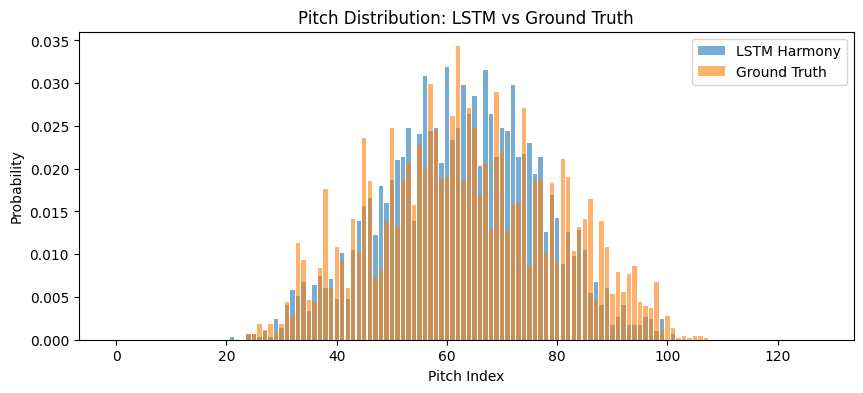

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(range(len(p)), p, alpha=0.6, label='LSTM Harmony')
plt.bar(range(len(q)), q, alpha=0.6, label='Ground Truth')
plt.xlabel("Pitch Index")
plt.ylabel("Probability")
plt.title("Pitch Distribution: LSTM vs Ground Truth")
plt.legend()
plt.show()


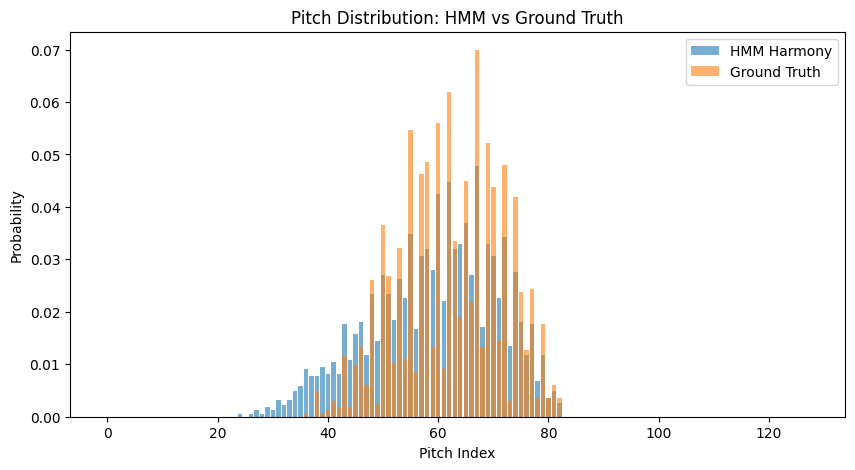

In [87]:
# Get a melody + ground truth harmony from dataset
melody_sample, harmony_gt = random.choice(dataset)
harmony_gt = harmony_gt.tolist()

# Get HMM harmony prediction
hmm_harmony = hmm_generate_harmony(melody_sample.tolist())

# Compute pitch distributions
p_hmm = get_pitch_distribution(hmm_harmony)
p_gt = get_pitch_distribution(harmony_gt)

# Plot pitch distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(range(len(p_hmm)), p_hmm, alpha=0.6, label='HMM Harmony')
plt.bar(range(len(p_gt)), p_gt, alpha=0.6, label='Ground Truth')
plt.xlabel("Pitch Index")
plt.ylabel("Probability")
plt.title("Pitch Distribution: HMM vs Ground Truth")
plt.legend()
plt.show()
